# Time Series Analysis in Finance

**Gathering data**

In [4]:
import yfinance as yf
import pandas as pd

# Define stock ticker and date range
ticker = "AAPL"  
start_date = "2022-01-01"
end_date = "2024-01-01"

# Download stock data
df = yf.download(ticker, start=start_date, end=end_date)

# Flatten MultiIndex columns if necessary
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]  # Keep only the first part of the tuple

# Save to CSV
csv_filename = "stock_data.csv"
df.to_csv(csv_filename)

# Print available column names
print("Downloaded Data (first 5 rows):")
print(df.head())

print("\nAvailable Columns:")
print(df.columns.tolist())


[*********************100%***********************]  1 of 1 completed

Downloaded Data (first 5 rows):
                 Close        High         Low        Open     Volume
Date                                                                 
2022-01-03  178.879913  179.734962  174.653874  174.771805  104487900
2022-01-04  176.609634  179.793920  176.039607  179.489254   99310400
2022-01-05  171.911850  177.071564  171.636666  176.521197   94537600
2022-01-06  169.042084  172.285336  168.688274  169.730043   96904000
2022-01-07  169.209137  171.145259  168.088742  169.916756   86709100

Available Columns:
['Close', 'High', 'Low', 'Open', 'Volume']


This script:

- Preprocesses and cleans the financial time series data (assumed to be in a CSV file).
- Decomposes the time series to visualize its trend, seasonal, and residual components.
- Calculates moving averages and generates simple trading signals.
- Implements a basic forecasting model using the Holt-Winters method.
- Evaluates and visualizes the forecast performance.

Initial Data (first 5 rows):
                 Close        High         Low        Open     Volume
Date                                                                 
2022-01-03  178.879913  179.734962  174.653874  174.771805  104487900
2022-01-04  176.609634  179.793920  176.039607  179.489254   99310400
2022-01-05  171.911850  177.071564  171.636666  176.521197   94537600
2022-01-06  169.042084  172.285336  168.688274  169.730043   96904000
2022-01-07  169.209137  171.145259  168.088742  169.916756   86709100
Not enough data for two full cycles of period 252. Using period = 250.


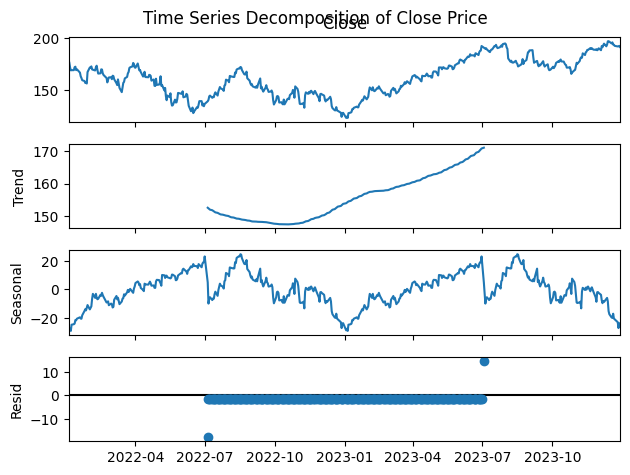

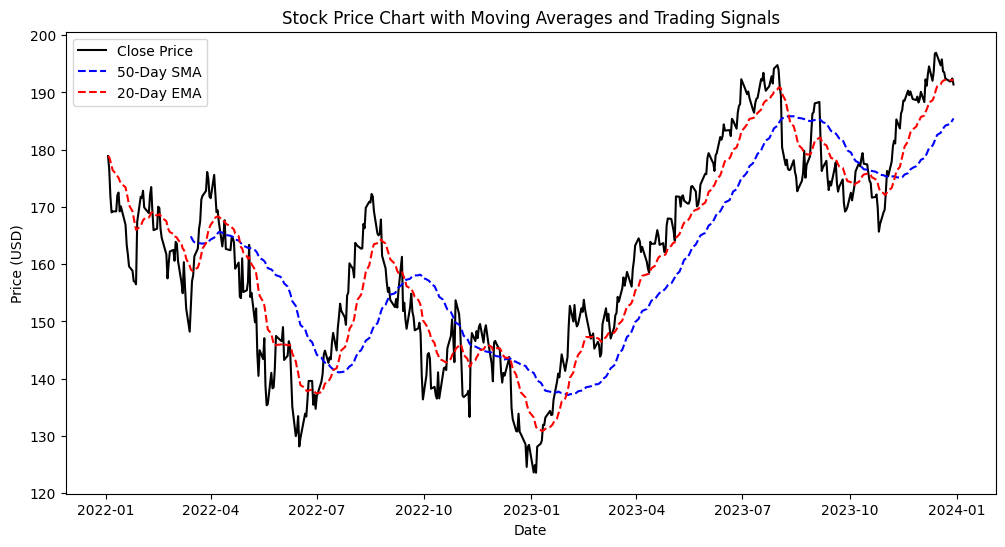

c:\Users\jonat\miniconda3\envs\FINN_41603_0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jonat\miniconda3\envs\FINN_41603_0\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jonat\miniconda3\envs\FINN_41603_0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\jonat\miniconda3\envs\FINN_41603_0\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction

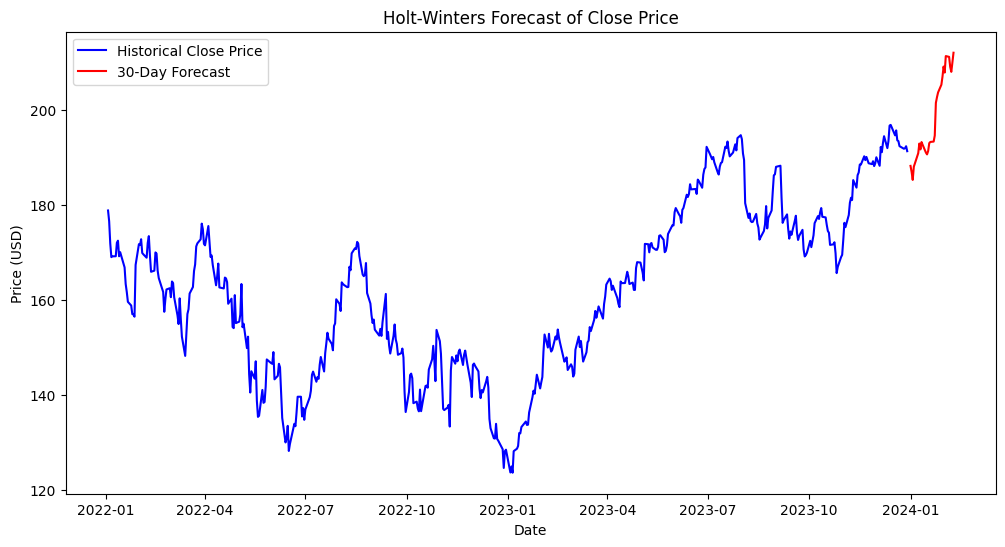

Forecast Summary Statistics:
         Forecast
count   30.000000
mean   198.231456
std      8.913744
min    185.327191
25%    191.153318
50%    193.370118
75%    207.742095
max    212.144075


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ============================
# 1. Data Preprocessing and Cleaning
# ============================
# Load and sort the time series data from CSV
df = pd.read_csv('stock_data.csv', index_col='Date', parse_dates=True)
df = df.sort_index()

# Forward-fill missing 'Close' values
df['Close'] = df['Close'].ffill()

print("Initial Data (first 5 rows):")
print(df.head())

# ============================
# 2. Time Series Decomposition and Visualization
# ============================
# Desired seasonal period (e.g., 252 trading days per year)
desired_period = 252
min_required_obs = 2 * desired_period

# If the DataFrame has fewer than 2 cycles, adjust the period
if len(df) < min_required_obs:
    period = int(len(df) / 2)
    print(f"Not enough data for two full cycles of period {desired_period}. Using period = {period}.")
else:
    period = desired_period

# Decompose the 'Close' time series using the determined period
result = seasonal_decompose(df['Close'], period=period)
result.plot()
plt.suptitle("Time Series Decomposition of Close Price")
plt.show()

# ============================
# 3. Moving Averages and Technical Analysis
# ============================
# Calculate 50-day Simple Moving Average (SMA) and 20-day Exponential Moving Average (EMA)
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Generate trading signals: Buy (1) when SMA_50 > EMA_20, otherwise Sell (-1)
df['Signal'] = np.where(df['SMA_50'] > df['EMA_20'], 1, -1)

# Plot the Close price along with moving averages
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='blue', linestyle='--')
plt.plot(df.index, df['EMA_20'], label='20-Day EMA', color='red', linestyle='--')
plt.title("Stock Price Chart with Moving Averages and Trading Signals")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# ============================
# 4. Time Series Forecasting
# ============================
# Fit a Holt-Winters model with additive trend and seasonal components
model = ExponentialSmoothing(df['Close'], seasonal_periods=period, trend='add', seasonal='add')
fitted_model = model.fit(optimized=True)

# Forecast the next 30 days
forecast = fitted_model.forecast(30)

# Ensure forecast index aligns with the last date in the dataset
last_date = df.index[-1]  # Get last date in dataset
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')  # 30 business days

# Assign the correct index to the forecast
forecast = pd.Series(forecast.values, index=forecast_index)

# Plot historical data and corrected forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical Close Price', color='blue')
plt.plot(forecast.index, forecast, label='30-Day Forecast', color='red')
plt.title("Holt-Winters Forecast of Close Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# ============================
# 5. Performance Evaluation and Analysis
# ============================
forecast_summary = pd.DataFrame({'Forecast': forecast})
print("Forecast Summary Statistics:")
print(forecast_summary.describe())
